In [1]:
pip install pytrends

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: C:\Users\OWNER\AppData\Local\Programs\Python\Python313\python.exe -m pip install --upgrade pip


In [7]:
from pytrends.request import TrendReq
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import font_manager, rc
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

In [3]:
pytrends = TrendReq(hl='ko', tz=540)

In [9]:
TIMEFRAME = "2024-01-01 2024-12-31"
GEO = "KR"        # 대한민국
GPROP = "news"    # '': 전체 웹, 'news': 뉴스, 'youtube': 유튜브 등

In [8]:
category_term = {
    "글로벌경제": "세계 경제",
    "금융": "금리",          # ← 앵커(공통)로도 사용
    "부동산": "부동산",
    "산업": "반도체",
    "일반": "물가",
    "증권": "주식"
}

In [10]:
anchor = "금리"  # 공통으로 넣을 앵커 키워드(위 딕셔너리의 값과 동일해야 함)

terms = list(category_term.values())
labels = list(category_term.keys())

batch_A_terms = [category_term["글로벌경제"],
                 category_term["금융"],   # anchor
                 category_term["부동산"],
                 category_term["산업"],
                 category_term["일반"]]

batch_B_terms = [category_term["금융"],  # anchor
                 category_term["증권"]]

def get_iot_df(term_list):
    """interest_over_time() DataFrame (date index, columns=terms, plus isPartial)"""
    pytrends.build_payload(term_list, geo=GEO, timeframe=TIMEFRAME, gprop=GPROP)
    df = pytrends.interest_over_time()
    if df is None or df.empty:
        return pd.DataFrame()
    df = df.drop(columns=['isPartial'], errors='ignore')
    return df

In [11]:
iot_A = get_iot_df(batch_A_terms)  # columns = ["세계 경제","금리","부동산","반도체","물가"]
iot_B = get_iot_df(batch_B_terms)  # columns = ["금리","주식"]

In [12]:
common = "금리"
aligned_index = iot_A.index.intersection(iot_B.index)
if aligned_index.empty:
    raise RuntimeError("두 배치의 기간이 겹치지 않습니다. TIMEFRAME을 확인하세요.")

a_anchor = iot_A.loc[aligned_index, common].astype(float)
b_anchor = iot_B.loc[aligned_index, common].astype(float)

In [13]:
mask = (a_anchor > 0) & (b_anchor > 0)
if mask.sum() == 0:
    raise RuntimeError("앵커(금리)의 겹치는 기간에 유효한 값이 없습니다.")

scale_ratio = np.median(a_anchor[mask] / b_anchor[mask])  # 견고한 스케일 비율(중앙값)
iot_B_rescaled = iot_B * scale_ratio

In [14]:
iot_B_rescaled = iot_B_rescaled.drop(columns=[common], errors='ignore')
iot_merged = iot_A.join(iot_B_rescaled, how='outer').sort_index()

In [15]:
rename_map = {v: k for k, v in category_term.items()}
iot_merged = iot_merged.rename(columns=rename_map)

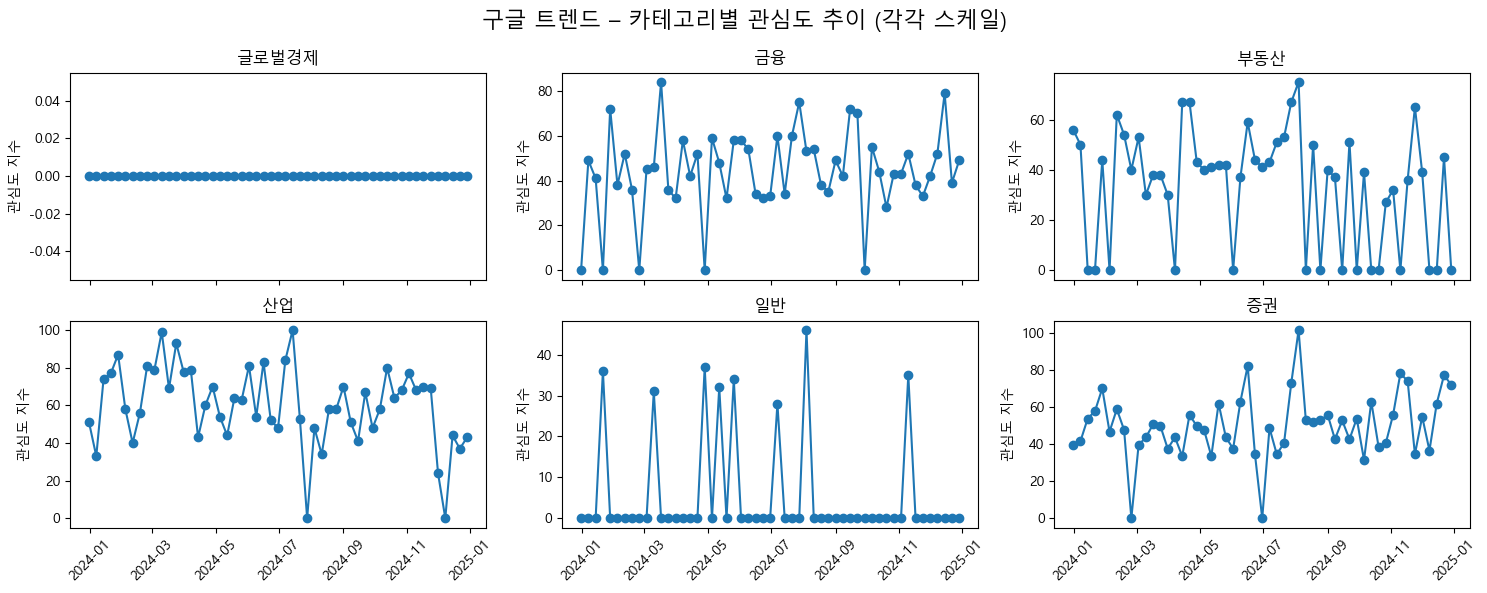

In [19]:
n_cat = len(iot_merged.columns)
ncol = 3  # 한 행에 몇 개씩 표시할지
nrow = -(-n_cat // ncol)  # 올림 나눗셈

fig, axes = plt.subplots(nrow, ncol, figsize=(15, nrow*3), sharex=True)
axes = axes.flatten()

for i, col in enumerate(iot_merged.columns):
    axes[i].plot(iot_merged.index, iot_merged[col], marker="o")
    axes[i].set_title(col)
    axes[i].set_ylabel("관심도 지수")
    axes[i].tick_params(axis='x', rotation=45)

# 남는 subplot은 숨기기
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("구글 트렌드 – 카테고리별 관심도 추이 (각각 스케일)", fontsize=16)
plt.tight_layout()
plt.show()

In [17]:
monthly = (iot_merged
           .resample("MS").mean()  # 월초 기준 평균
           .round(1))

print("월 평균 테이블(상위 5행):")
display(monthly.head())

월 평균 테이블(상위 5행):


,글로벌경제,금융,부동산,산업,일반,증권
date,,,,,,
2023-12-01,0.0,0.0,56.0,51.0,0.0,39.5
2024-01-01,0.0,40.5,23.5,67.8,9.0,55.8
2024-02-01,0.0,31.5,39.0,58.8,0.0,38.3
2024-03-01,0.0,48.6,37.8,83.6,6.2,44.2
2024-04-01,0.0,38.0,44.2,63.0,9.2,45.6


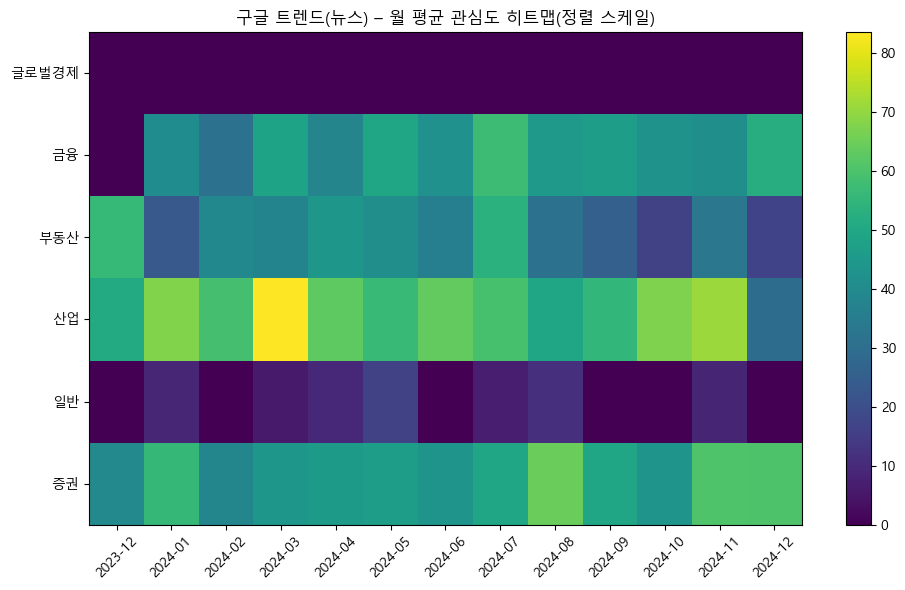

In [18]:
plt.figure(figsize=(10,6))
data = monthly.to_numpy().T
plt.imshow(data, aspect="auto")
plt.yticks(range(len(monthly.columns)), monthly.columns)
plt.xticks(range(len(monthly.index)), [d.strftime("%Y-%m") for d in monthly.index], rotation=45)
plt.title("구글 트렌드(뉴스) – 월 평균 관심도 히트맵(정렬 스케일)")
plt.colorbar()
plt.tight_layout()
plt.show()